In [1]:
from pathlib import Path 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme()


In [2]:
score_dir = Path(Path.home(), "Documents/xray/score_bench/data/3ca7/82_native_4x_decoys/4_state_ref")
n_state = 4


In [3]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fp(x,L,k,x0):
    return (L * k * np.exp(-k * (x - x0))) / (1 + np.exp(-k * (x - x0)))**2

def fdp(x,L,k,x0): 
    return (L * k**2 * np.exp(-2*k * (x - x0)) * (-np.exp(k * (x - x0)) + 1)) / (1 + np.exp(-k * (x - x0)))**3

In [4]:
score_df = pd.read_csv(Path(score_dir, "0_native_{}x.csv".format(n_state)))
native_score, native_rmsd, native_prior = score_df[score_df["native"] == 1]["ml"], score_df[score_df["native"] == 1]["rmsd_avg"], score_df[score_df["native"] == 1]["ff"]
score_df = score_df[score_df["native"] == 0]
score_df.head()

,Unnamed: 0,pdb_file,native,ml,rmsd_avg,ff,r_free,r_work,r_all
0,0,/wynton/group/sali/mhancock/xray/decoys/data/3...,0,5.333370,0.402541,354.090316,0.512995,0.519325,0.518879
1,1,/wynton/group/sali/mhancock/xray/decoys/data/3...,0,5.357994,0.359084,381.295197,0.492032,0.509143,0.507950
2,2,/wynton/group/sali/mhancock/xray/decoys/data/3...,0,4.520581,0.054231,305.311311,0.141949,0.145646,0.145377
3,3,/wynton/group/sali/mhancock/xray/decoys/data/3...,0,5.324541,0.489817,376.966714,0.526914,0.530022,0.529816
4,4,/wynton/group/sali/mhancock/xray/decoys/data/3...,0,5.370008,0.539184,375.884727,0.543140,0.539127,0.539464


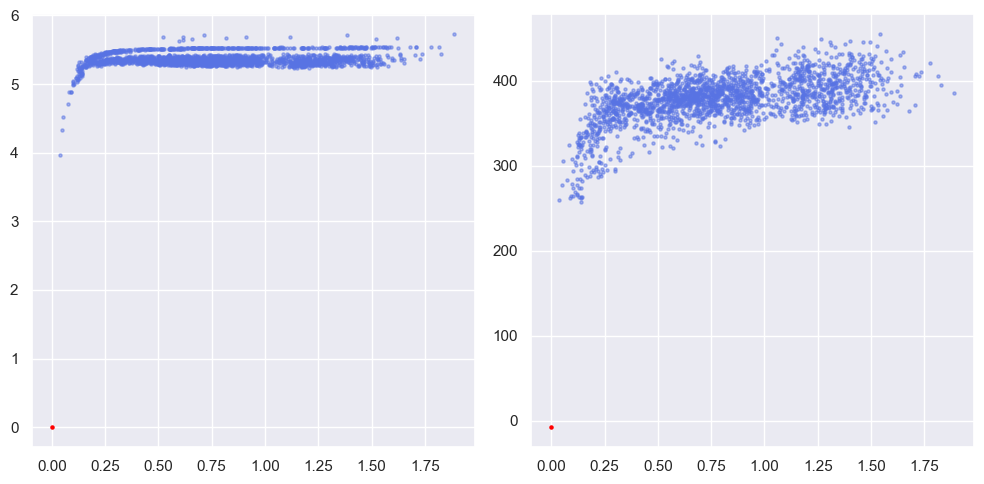

In [5]:
fig_file = Path(Path.home(), "Desktop/plt_fit_score_rmsd_single.png")
fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
axs[0].scatter(score_df["rmsd_avg"], score_df["ml"], c="#5873E3", alpha=0.5, s=5)
axs[0].scatter(native_rmsd, native_score, c="red", s=5)
axs[1].scatter(score_df["rmsd_avg"], score_df["ff"], c="#5873E3", alpha=0.5, s=5)
axs[1].scatter(native_rmsd, native_prior, c="red", s=5)
plt.savefig(fig_file, dpi=300)


[ 5.64067532 15.81052981 -0.03615282]
0.685


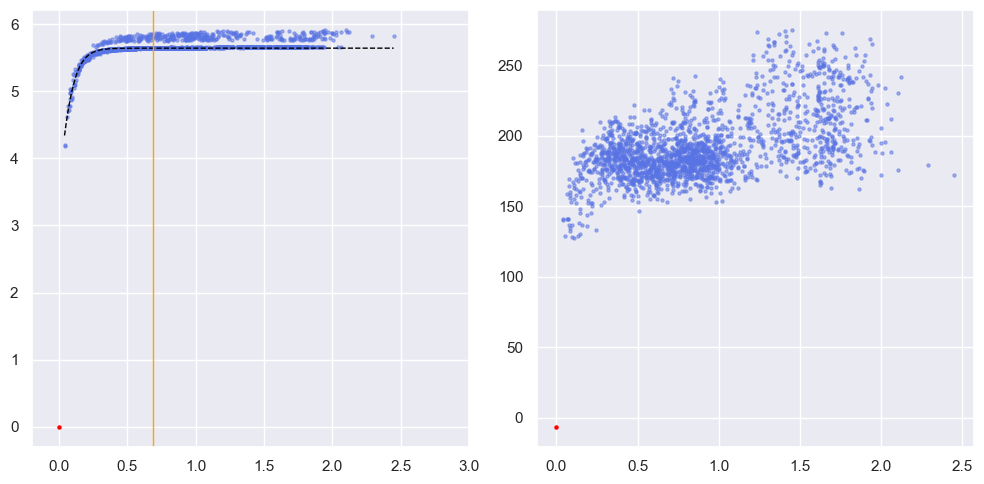

In [134]:
xs = score_df[(score_df["rmsd_avg"] < .5) & (score_df["rmsd_avg"] > .01)]["rmsd_avg"]
ys = score_df[(score_df["rmsd_avg"] < .5) & (score_df["rmsd_avg"] > .01)]["ml"]
# xs = score_df["rmsd_avg"]
# ys = score_df["ml"]

params, covariance = curve_fit(logistic_func,xs,ys,[5.84455246, 10.3717428, -0.07328709], maxfev=10000)
L_fit, k_fit, x0_fit = params
print(params)

rmsd_min = score_df["rmsd_avg"].min()
rmsd_max = score_df["rmsd_avg"].max()

linespace = [rmsd_min + x*(rmsd_max-rmsd_min)/1000 for x in range(1000)]

first_fp_zero = get_first_fp_zero(L_fit, k_fit, x0_fit)
print(first_fp_zero)

fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)

axs[0].set_xlim(-.2, 3.0) 
axs[0].scatter(score_df["rmsd_avg"], score_df["ml"], c="#5873E3", alpha=0.5, s=5)
axs[0].scatter(native_rmsd, native_score, c="red", s=5)

axs[0].plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")
axs[0].axvline(x=first_fp_zero, c="orange", linewidth=1, label = 'axvline - full height')

axs[1].scatter(score_df["rmsd_avg"], score_df["ff"], c="#5873E3", alpha=0.5, s=5)
axs[1].scatter(native_rmsd, native_prior, c="red", s=5)


In [47]:


# linespace = [x/ for x in range(200)]

In [55]:
def get_first_fp_zero(L, k, x0):
    linespace = [x/200 for x in range(1000)]
    first_fp_zero = 0 
    fp_vals = [fp(x, L_fit, k_fit, x0_fit) for x in linespace]
    for i in range(len(fp_vals)):
        fp_val = fp_vals[i]
        if fp_val <= 1e-3: 
            first_fp_zero = linespace[i]
            break
        
    return first_fp_zero

first_fp_zero

0.6859024069513088

In [108]:
score_dfs = list() 
for i in range(40): 
    score_df = pd.read_csv(Path(Path.home(), "Documents/xray/score_bench/data/3ca7/80_native_1x_decoys/1_state_ref/{}_native_1x.csv".format(i)))
    score_dfs.append(score_df)

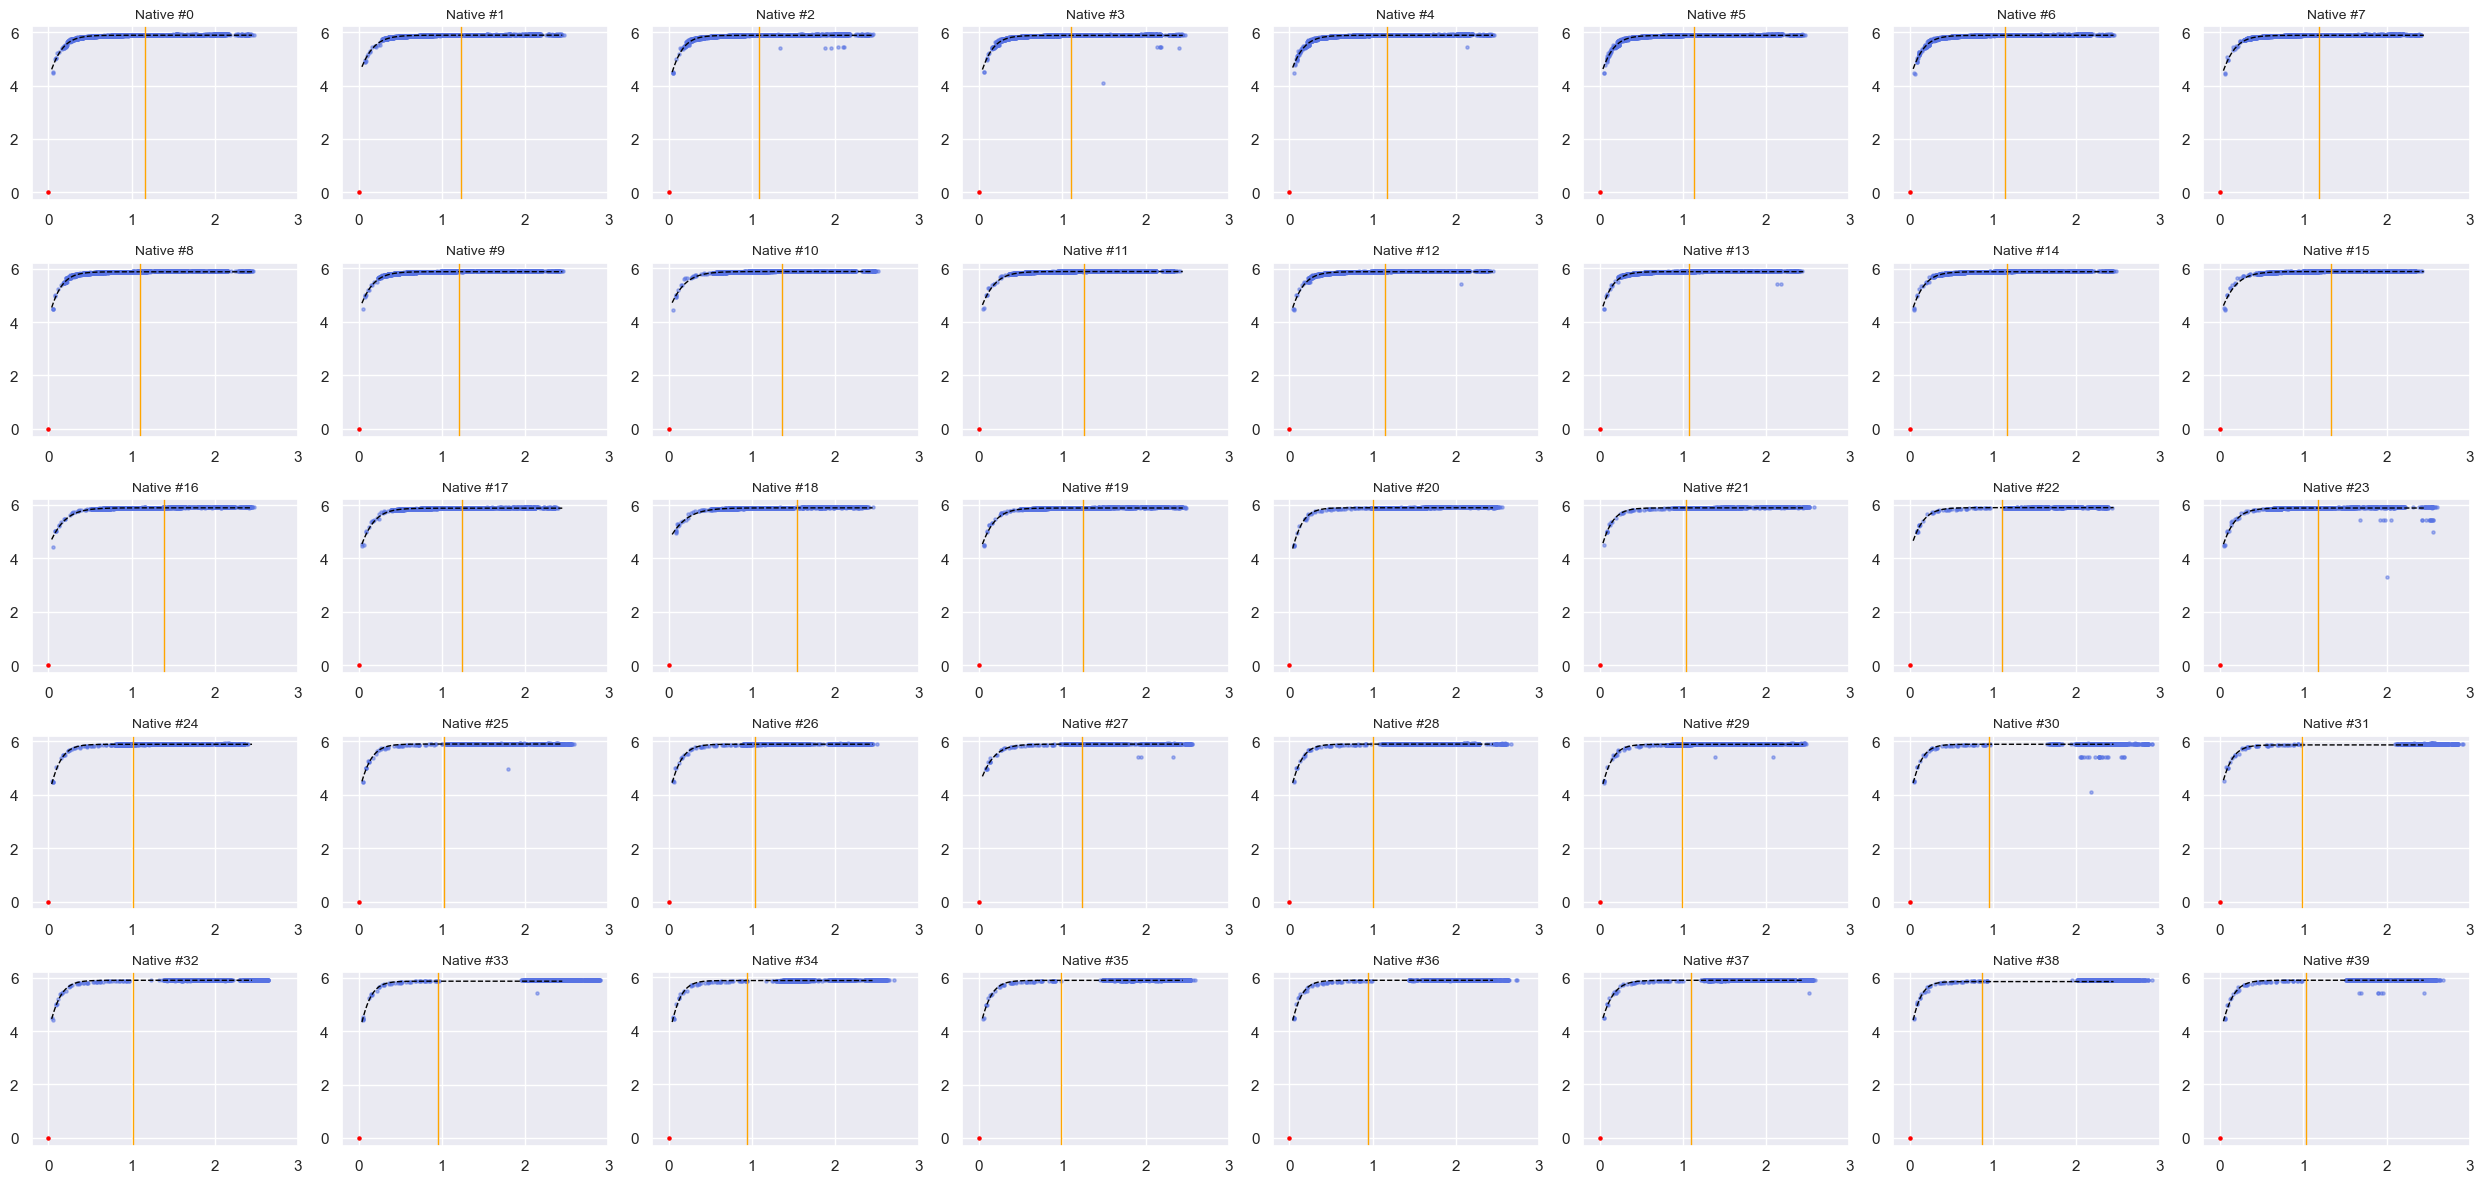

In [109]:
fig_file = Path(Path.home(), "Desktop/plot_fit_score_rmsd_curves.png")

fig, axs = plt.subplots(5, 8, figsize=(25,12), tight_layout=True)

stats_df = pd.DataFrame() 
for i in range(40): 
    score_df = score_dfs[i]
    native_score, native_rmsd = score_df[score_df["native"] == 1]["ml"], score_df[score_df["native"] == 1]["rmsd_avg"]
    score_df = score_df[score_df["native"] == 0]

    xs = score_df[(score_df["rmsd_avg"] < 2)]["rmsd_avg"]
    ys = score_df[(score_df["rmsd_avg"] < 2)]["ml"]

    params, covariance = curve_fit(logistic_func,xs,ys,[5.84455246, 10.3717428, -0.07328709], maxfev=10000)
    L_fit, k_fit, x0_fit = params
    stats_df.loc[i, "L"] = L_fit
    stats_df.loc[i, "k"] = k_fit
    stats_df.loc[i, "x0"] = x0_fit

    first_fp_zero = get_first_fp_zero(L_fit, k_fit, x0_fit)
    stats_df.loc[i, "first_fp_zero"] = first_fp_zero

    x_row = i // 8
    x_col = i % 8

    if L_fit < 6 and k_fit > 4: 
        plot_fit = True 
    else: 
        plot_fit = False 
    stats_df.loc[i, "plot_fit"] = plot_fit

    ax = axs[x_row, x_col]
    ax.set_title("Native #{}".format(i), fontsize=10)
    ax.set_xlim(-.2, 3.0) 
    ax.scatter(score_df["rmsd_avg"], score_df["ml"], c="#5873E3", alpha=0.5, s=5)
    ax.scatter(native_rmsd, native_score, c="red", s=5)

    if plot_fit: 
        ax.plot(linespace, [logistic_func(x, L_fit, k_fit, x0_fit) for x in linespace], c="black", linewidth=1, linestyle="dashed")
        ax.axvline(x=first_fp_zero, c="orange", linewidth=1, label = 'axvline - full height')

plt.savefig(fig_file, dpi=300)



In [110]:
for i in range(len(stats_df)): 
    if not stats_df.loc[i, "plot_fit"]: 
        continue 

    L_fit = stats_df.loc[i, "L"] 
    k_fit = stats_df.loc[i, "k"]
    x0_fit = stats_df.loc[i, "x0"]

    score_df = score_dfs[i]

    var = 0 
    for j in range(len(score_df)): 
        ml_decoy = score_df.iloc[j]["ml"]
        rmsd_decoy = score_df.iloc[j]["rmsd_avg"]

        ml_logit = logistic_func(rmsd_decoy, L_fit, k_fit, x0_fit)

        var = var + (ml_decoy - ml_logit)**2

    var = var/(len(score_df)-1)
    stats_df.loc[i, "var"] = var

In [98]:
stats_df.head()

,L,k,x0,first_fp_zero,plot_fit,var
0,5.676803,13.006499,-0.058978,0.805,True,0.012068
1,5.608196,13.190928,-0.057220,0.795,True,0.017434
2,5.626342,11.504653,-0.081365,0.885,True,0.016525
3,5.667534,12.597687,-0.064828,0.825,True,0.012897
4,5.647374,11.092610,-0.089685,0.910,True,0.015164


In [111]:
native_df = pd.read_csv(Path(Path.home(), "Documents/xray/dev/17_synthetic_native/data/scores/1_state_ref.csv"))
native_df.head()

,Unnamed: 0,native,pdb_file,r_free,r_work,r_all,ml,ff,rmsd_avg,rmsd_ord,rmsd_dom,weight_delta
0,0,0.0,/wynton/home/sali/mhancock/xray/data/pdbs/3ca7...,0.355257,0.349202,0.349658,5.412294,5.429363,0.180712,0.180712,0.180712,0.0
1,1,0.0,/wynton/home/sali/mhancock/xray/data/pdbs/3ca7...,0.465312,0.465537,0.465522,5.736718,5.429363,0.318483,0.318483,0.318483,0.0
2,2,0.0,/wynton/home/sali/mhancock/xray/data/pdbs/3ca7...,0.386710,0.383558,0.383783,5.478936,5.429363,0.205096,0.205096,0.205096,0.0
3,3,0.0,/wynton/home/sali/mhancock/xray/data/pdbs/3ca7...,0.357893,0.363619,0.363204,5.441196,5.429363,0.177475,0.177475,0.177475,0.0
4,4,0.0,/wynton/home/sali/mhancock/xray/data/pdbs/3ca7...,0.253118,0.259604,0.259142,5.174665,5.429363,0.102308,0.102308,0.102308,0.0


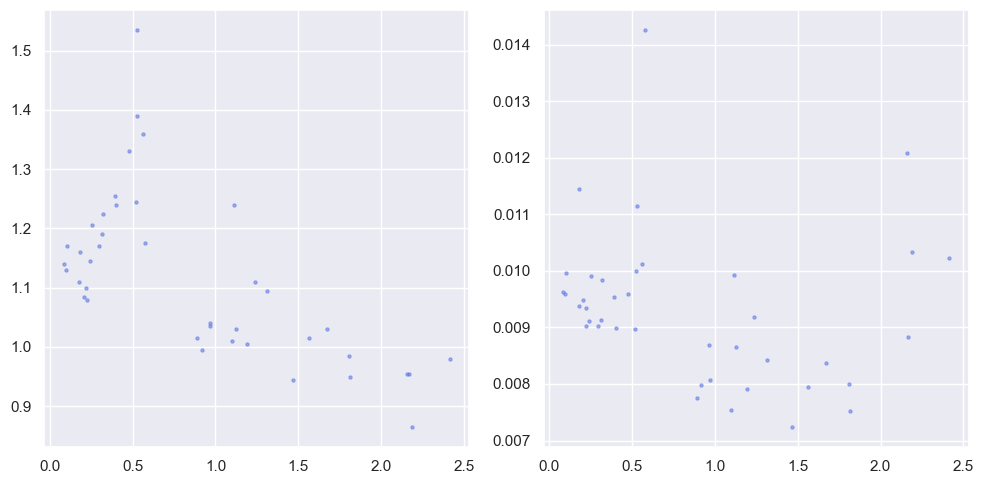

In [112]:
fig_file = Path(Path.home(), "Desktop/plot_fit_score_rmsd_correlations.png")
fig, axs = plt.subplots(1, 2, figsize=(10,5), tight_layout=True)
axs[0].scatter(native_df["rmsd_avg"], stats_df["first_fp_zero"], c="#5873E3", alpha=0.5, s=5)
axs[1].scatter(native_df["rmsd_avg"], stats_df["var"], c="#5873E3", alpha=0.5, s=5)

plt.savefig(fig_file, dpi=300)